In [1]:
'''
Code Author: Spencer Turenne

The data contains information about individual National Football League games for the seasons starting in 1966 until present.
After 1978 all games also include betting spreads.
In other csv files associated with the data you can find information on teams and staidums.

This section contains information about the author and project. It also conatins imports for python libraries.
'''
import pandas
import matplotlib
import matplotlib.pyplot
import numpy


In [2]:
scores = pandas.read_csv("spreadspoke_scores.csv")
betting_odds = pandas.DataFrame(data=scores, copy=True)
betting_odds = betting_odds.dropna(subset=betting_odds.columns[:13])
betting_odds = betting_odds.loc[betting_odds['schedule_season'] > 1978]
betting_odds['team_winner'] = None
betting_odds['team_winner_home'] = None
betting_odds['spread_result'] = None
betting_odds['score_total'] = (betting_odds['score_home'] + betting_odds['score_away'])

print(betting_odds.shape)

team_info = pandas.read_csv("nfl_teams.csv")
print(team_info.shape)


for row in betting_odds.index:
    for team in ['team_home', 'team_away']:
        team_row = team_info.loc[team_info['team_name'] == betting_odds.at[row, team]]
        betting_odds.at[row, team] = team_row.at[team_row.index[0], 'team_id']
    if betting_odds.at[row, "score_home"] > betting_odds.at[row, "score_away"]: #Home team wins.
        betting_odds.at[row, 'team_winner'] = betting_odds.at[row, 'team_home']
        betting_odds.at[row, 'team_winner_home'] = True
        if betting_odds.at[row, team] == betting_odds.at[row, 'team_home']: #This means home team was the favorite.
            betting_odds.at[row, 'spread_result'] = betting_odds.at[row, "score_away"] - betting_odds.at[row, "score_home"]
        else:
            betting_odds.at[row, 'spread_result'] = betting_odds.at[row, "score_home"] - betting_odds.at[row, "score_away"]
    else:
        betting_odds.at[row, 'team_winner'] = betting_odds.at[row, 'team_away']
        betting_odds.at[row, 'team_winner_home'] = False
        if betting_odds.at[row, team] == betting_odds.at[row, 'team_away']: #This means away team was the favorite.
            betting_odds.at[row, 'spread_result'] = betting_odds.at[row, "score_home"] - betting_odds.at[row, "score_away"]
        else:
            betting_odds.at[row, 'spread_result'] = betting_odds.at[row, "score_away"] - betting_odds.at[row, "score_home"]
            
            

(10445, 21)
(43, 8)


Text(0.5, 1.0, 'Spread Outcomes')

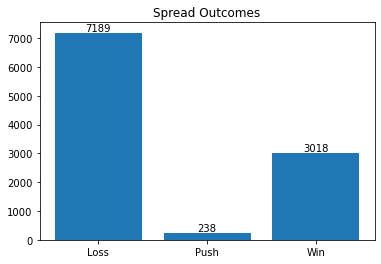

In [3]:
spread_wins = {-1:0, 0:0, 1:0}
for real_spread, bet_spread in zip(betting_odds['spread_result'], betting_odds['spread_favorite']):
    if real_spread > bet_spread: #Bet was LOST
        spread_wins[-1] += 1
    elif real_spread == bet_spread: #Bet was PUSHED (Get money back, but don't make more)
        spread_wins[0] += 1
    else: #Bet was WON
        spread_wins[1] += 1


matplotlib.pyplot.bar(x=['Loss','Push','Win'], height=spread_wins.values())
for x, y in zip(range(len(spread_wins.values())), spread_wins.values()):
    matplotlib.pyplot.text(x, y + 50, y, ha='center')
matplotlib.pyplot.title("Spread Outcomes")

0.20160596501290506
0.22139374820762833


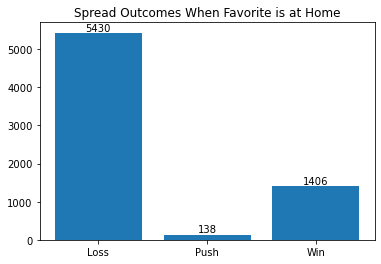

In [4]:
home_favorite_spread_wins = {-1:0, 0:0, 1:0}
for row in betting_odds[betting_odds['team_home'] == betting_odds['team_favorite_id']].index:
    if betting_odds.at[row, 'spread_result'] > betting_odds.at[row, 'spread_favorite']: #Bet was LOST
        home_favorite_spread_wins[-1] += 1
    elif betting_odds.at[row, 'spread_result'] == betting_odds.at[row, 'spread_favorite']: 
        #Bet was PUSHED (Get money back, but don't make more)
        home_favorite_spread_wins[0] += 1
    else: #Bet was WON
        home_favorite_spread_wins[1] += 1


matplotlib.pyplot.bar(x=['Loss','Push','Win'], height=home_favorite_spread_wins.values())
for x, y in zip(range(len(home_favorite_spread_wins.values())), home_favorite_spread_wins.values()):
    matplotlib.pyplot.text(x, y + 50, y, ha='center')
matplotlib.pyplot.title("Spread Outcomes When Favorite is at Home")
print(home_favorite_spread_wins[1] / (home_favorite_spread_wins[-1] + home_favorite_spread_wins[0] + home_favorite_spread_wins[1]))
print((home_favorite_spread_wins[1] +  home_favorite_spread_wins[0])/ (home_favorite_spread_wins[-1] + home_favorite_spread_wins[0] + home_favorite_spread_wins[1]))

3
46


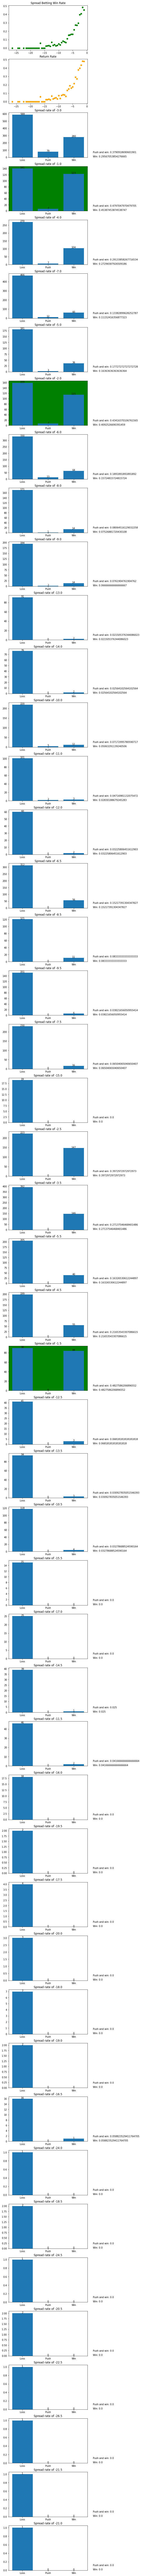

In [4]:
home_favorite_spreads = {}
for row in betting_odds[betting_odds['team_home'] == betting_odds['team_favorite_id']].index:
    row_spread = betting_odds.at[row, 'spread_favorite']
    if row_spread not in home_favorite_spreads.keys():
        home_favorite_spreads[row_spread] = {'count': 0, -1: 0, 0: 0, 1: 0}
    home_favorite_spreads[row_spread]['count'] += 1
    if betting_odds.at[row, 'spread_result'] > betting_odds.at[row, 'spread_favorite']: #Bet was LOST
        home_favorite_spreads[row_spread][-1] += 1
    elif betting_odds.at[row, 'spread_result'] == betting_odds.at[row, 'spread_favorite']: 
        #Bet was PUSHED (Get money back, but don't make more)
        home_favorite_spreads[row_spread][0] += 1
    else: #Bet was WON
        home_favorite_spreads[row_spread][1] += 1
figure, axes = matplotlib.pyplot.subplots(2 + int(len(home_favorite_spreads.keys())))

#figure.set_figwidth(20)
figure.set_figheight(200)
totals = 0
for a, k in zip(axes[2:], home_favorite_spreads.keys()):
    bet_result = home_favorite_spreads[k]
    bet_result.pop('count')
    a.bar(x=['Loss','Push','Win'], height=bet_result.values())
    win_rate = bet_result[1] / (bet_result[-1] + bet_result[0] + bet_result[1])
    return_rate = (bet_result[1] + bet_result[0]) / (bet_result[-1] + bet_result[0] + bet_result[1])
    a.set_title(f'Spread rate of {k}')
    a.text(2.75, 0, f'Win: {win_rate}')
    a.text(2.75, max(bet_result.values())*.1, f'Push and win: {return_rate}')
    if win_rate > .4:
        a.set_facecolor('green')
        totals += 1
    for x, y in zip(range(len(bet_result.values())), bet_result.values()):
        a.text(x, y, y, ha='center')
        
    axes[0].scatter(x=k, y=win_rate, color="green")
    axes[1].scatter(x=k, y=return_rate, color="orange")
axes[0].set_title("Spread Betting Win Rate")
axes[1].set_title("Return Rate")
print(totals)
print(len(axes[2:]))


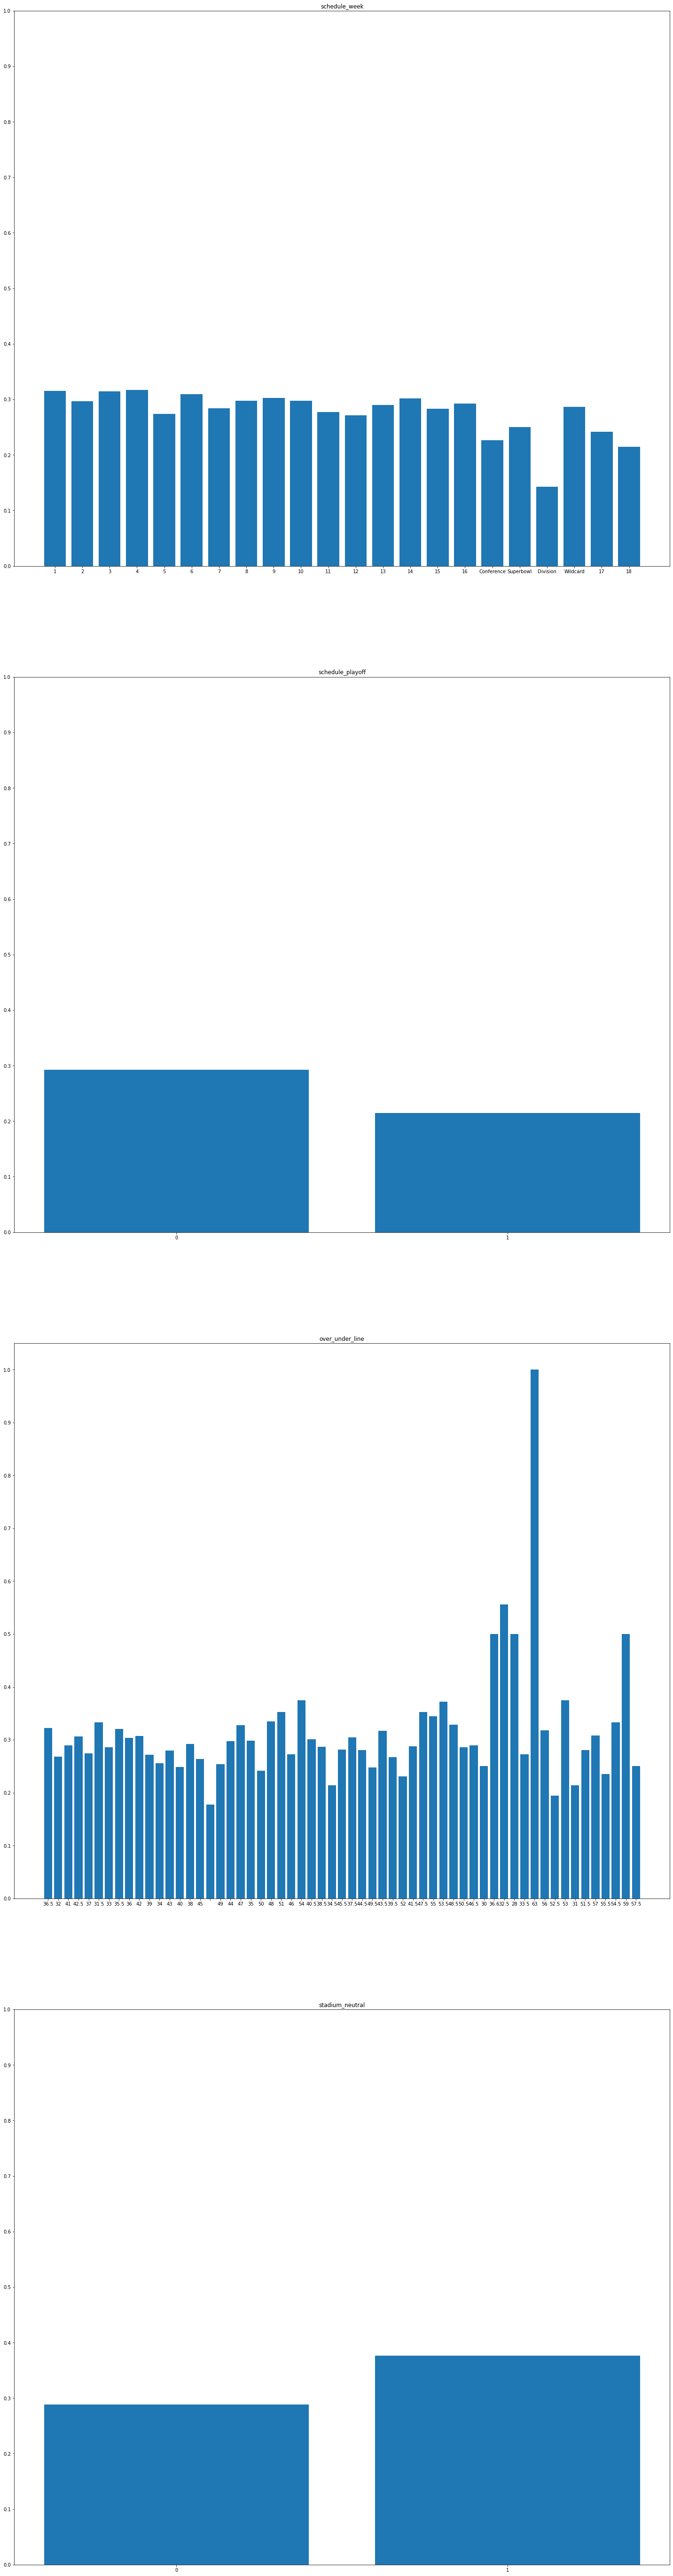

In [6]:
columns =  {}
totals = {}
for col in list(betting_odds.columns):
    if col in ['schedule_week', 'schedule_playoff', 'over_under_line', 'stadium_neutral']:
        columns[col] = {}
        totals[col] = {}
for row in betting_odds[betting_odds['spread_result'] < betting_odds['spread_favorite']].index:
    for column in columns:
        if betting_odds.at[row, column] not in columns[column].keys():
            columns[column][betting_odds.at[row, column]] = 0
        columns[column][betting_odds.at[row, column]] += 1
for row in betting_odds.index:
    for column in columns:
        if betting_odds.at[row, column] not in totals[column].keys():
            totals[column][betting_odds.at[row, column]] = 0
        totals[column][betting_odds.at[row, column]] += 1

figure, axes = matplotlib.pyplot.subplots(len(columns.keys()), 1)
figure.set_figwidth(25)
figure.set_figheight(100)
for a, k in zip(axes, columns.keys()):
    temp_list = [columns[k][i] / totals[k][i] for i in list(columns[k].keys())]
    a.bar(x=list(columns[k].keys()), height=temp_list)
    a.set_title(k)
    a.set_yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
    a.set_xticks(list(columns[k].keys()))
    

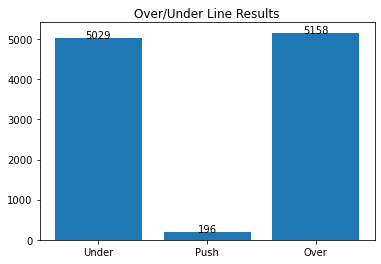

In [7]:
over_wins = {-1:0, 0:0, 1:0}
for real_score, bet_score in zip(betting_odds['score_total'], betting_odds['over_under_line']):
    try:
        if real_score > float(bet_score): #Bet was won if bet was under.
            over_wins[-1] += 1
        elif real_score == float(bet_score): #Bet was PUSHED (Get money back, but don't make more)
            over_wins[0] += 1
        else: #Bet was won if bet was over.
            over_wins[1] += 1
    except:
        pass #Removes null values that are not actually null.

matplotlib.pyplot.bar(x=['Under','Push','Over'], height=over_wins.values())
matplotlib.pyplot.title("Over/Under Line Results")
for x, y in zip(range(len(over_wins.values())), over_wins.values()):
    matplotlib.pyplot.text(x, y, y, ha='center')

54
67


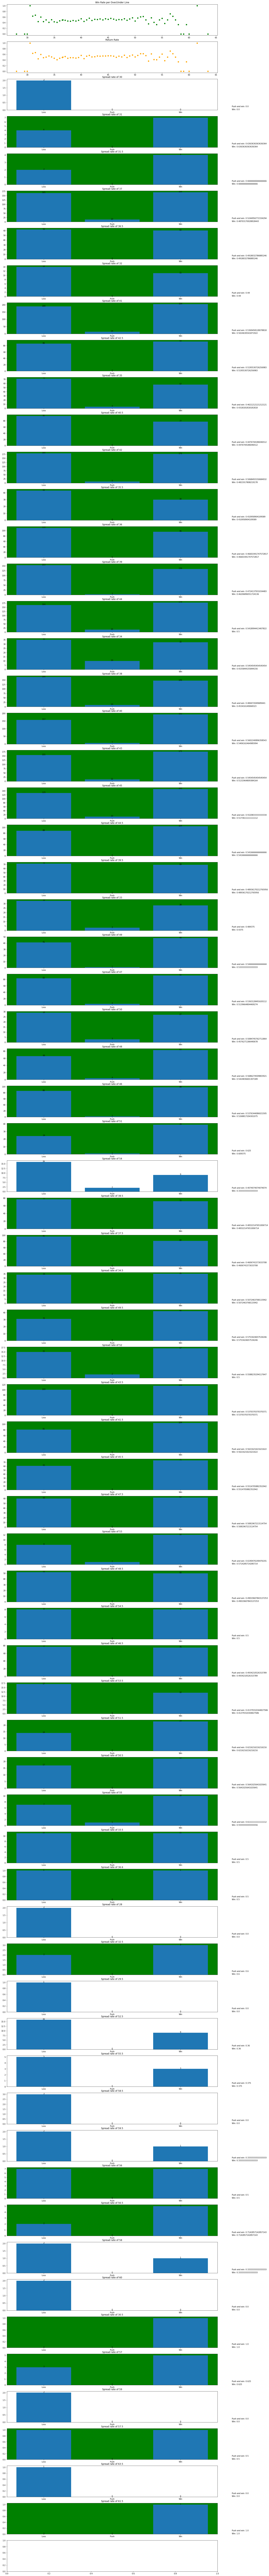

In [5]:
home_favorite_overunder = {}
for row in betting_odds[betting_odds['team_home'] == betting_odds['team_favorite_id']].index:
    try:
        overunder = betting_odds.at[row, 'over_under_line']
        if overunder not in home_favorite_overunder.keys():
            home_favorite_overunder[overunder] = {'count': 0, -1: 0, 0: 0, 1: 0}
        home_favorite_overunder[overunder]['count'] += 1
        if betting_odds.at[row, 'score_total'] > float(betting_odds.at[row, 'over_under_line']): #Bet was LOST
            home_favorite_overunder[overunder][-1] += 1
        elif betting_odds.at[row, 'score_total'] == float(betting_odds.at[row, 'over_under_line']): 
            #Bet was PUSHED (Get money back, but don't make more)
            home_favorite_overunder[overunder][0] += 1
        else: #Bet was WON
            home_favorite_overunder[overunder][1] += 1        
    except:
        pass #Removes nulls that are not nulls
figure, axes = matplotlib.pyplot.subplots(2 + int(len(home_favorite_overunder.keys())))

figure.set_figwidth(20)
figure.set_figheight(250)

over_40 = 0
home_favorite_overunder.pop(' ')
for a, k in zip(axes[2:], home_favorite_overunder.keys()):
    bet_result = home_favorite_overunder[k]
    bet_result.pop('count')
    a.bar(x=['Loss','Push','Win'], height=bet_result.values())
    
    try:
        win_rate = bet_result[1] / (bet_result[-1] + bet_result[0] + bet_result[1])
        return_rate = (bet_result[1] + bet_result[0]) / (bet_result[-1] + bet_result[0] + bet_result[1])
    except:
        return_rate = 0
        win_rate = 0
    a.set_title(f'Spread rate of {k}')
    a.text(2.75, 0, f'Win: {win_rate}')
    a.text(2.75, max(bet_result.values())*.1, f'Push and win: {return_rate}')
    if win_rate > .4:
        a.set_facecolor('green')
        over_40 += 1
    for x, y in zip(range(len(bet_result.values())), bet_result.values()):
        a.text(x, y, y, ha='center')
        
    axes[0].scatter(x=float(k), y=win_rate, color="green")
    axes[1].scatter(x=float(k), y=return_rate, color="orange")
axes[0].set_title("Win Rate per Over/Under Line")
axes[1].set_title("Return Rate")
print(over_40)
print(len(axes[2:]))

In [16]:
avg = 0.0
sample = 0
for real_spread in betting_odds['score_total']:
    avg += real_spread
    sample += 1
avg = avg / sample
print(avg)

42.744758257539495
